In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/ashrae.zip ashrae.zip
!unzip -q ashrae.zip

Mounted at /content/drive


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff

from IPython.core.pylabtools import figsize
from plotly.offline import init_notebook_mode,iplot,plot

%matplotlib inline
init_notebook_mode(connected=True)
plt.style.use("ggplot")

# importer les fichiers .py sur le notebook
%run utils.py

In [4]:
building = pd.read_csv('/content/building_metadata.csv')
weather = pd.read_csv('/content/weather_train.csv')
train = pd.read_csv('/content/train.csv')

train['meter_cat'] = train['meter'].map({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
train['meter_cat'] = train['meter_cat'].astype("category")
train.loc[(train.meter_cat == 'electricity'),'meter_reading'] = train['meter_reading'] * 0.2931 # convertir du kwh vers kbtu

In [47]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [48]:
train.head()

,building_id,meter,timestamp,meter_reading,meter_cat
0,0,0,2016-01-01 00:00:00,0.0,electricity
1,1,0,2016-01-01 00:00:00,0.0,electricity
2,2,0,2016-01-01 00:00:00,0.0,electricity
3,3,0,2016-01-01 00:00:00,0.0,electricity
4,4,0,2016-01-01 00:00:00,0.0,electricity


In [49]:
train.head()

,building_id,meter,timestamp,meter_reading,meter_cat
0,0,0,2016-01-01 00:00:00,0.0,electricity
1,1,0,2016-01-01 00:00:00,0.0,electricity
2,2,0,2016-01-01 00:00:00,0.0,electricity
3,3,0,2016-01-01 00:00:00,0.0,electricity
4,4,0,2016-01-01 00:00:00,0.0,electricity


In [50]:
print('Nombre des valeurs manquantes dans train:' ,np.sum(train.isnull().values))
print('Nombre des valeurs manquantes dans weather',np.sum(weather.isnull().values))
print('Nombre des valeurs manquantes dans building:',np.sum(building.isnull().values))

Nombre des valeurs manquantes dans train: 0
Nombre des valeurs manquantes dans weather 136820
Nombre des valeurs manquantes dans building: 1868


In [51]:
print(weather)

        site_id            timestamp  ...  wind_direction  wind_speed
0             0  2016-01-01 00:00:00  ...             0.0         0.0
1             0  2016-01-01 01:00:00  ...            70.0         1.5
2             0  2016-01-01 02:00:00  ...             0.0         0.0
3             0  2016-01-01 03:00:00  ...             0.0         0.0
4             0  2016-01-01 04:00:00  ...           250.0         2.6
...         ...                  ...  ...             ...         ...
139768       15  2016-12-31 19:00:00  ...           180.0         5.7
139769       15  2016-12-31 20:00:00  ...           180.0         7.7
139770       15  2016-12-31 21:00:00  ...           180.0         5.1
139771       15  2016-12-31 22:00:00  ...           170.0         4.6
139772       15  2016-12-31 23:00:00  ...           180.0         8.8

[139773 rows x 9 columns]


In [5]:
building = reduce_mem_usage(building)
weather = reduce_mem_usage(weather)
train = reduce_mem_usage(train)

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 65.4%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 4.51 MB
Decreased by 53.0%
Memory usage of dataframe is 636.23 MB
Memory usage after optimization is: 193.18 MB
Decreased by 69.6%


In [6]:
weather = time_features(weather)
train  = time_features(train)

In [54]:
print(train)

          building_id  meter           timestamp  ...  hour dayofweek  month
0                   0      0 2016-01-01 00:00:00  ...     0         4      1
1                   1      0 2016-01-01 00:00:00  ...     0         4      1
2                   2      0 2016-01-01 00:00:00  ...     0         4      1
3                   3      0 2016-01-01 00:00:00  ...     0         4      1
4                   4      0 2016-01-01 00:00:00  ...     0         4      1
...               ...    ...                 ...  ...   ...       ...    ...
20216095         1444      0 2016-12-31 23:00:00  ...    23         5     12
20216096         1445      0 2016-12-31 23:00:00  ...    23         5     12
20216097         1446      0 2016-12-31 23:00:00  ...    23         5     12
20216098         1447      0 2016-12-31 23:00:00  ...    23         5     12
20216099         1448      0 2016-12-31 23:00:00  ...    23         5     12

[20216100 rows x 8 columns]


In [55]:
train.shape

(20216100, 8)

In [56]:
print("Percentage of missing values in the train dataset")
train.isna().sum()

Percentage of missing values in the train dataset


building_id      0
meter            0
timestamp        0
meter_reading    0
meter_cat        0
hour             0
dayofweek        0
month            0
dtype: int64

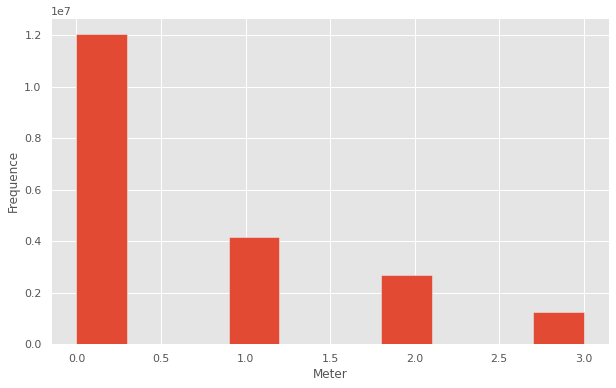

In [57]:
fig , ax = plt.subplots(1,1 , figsize = (10,6))
plt.hist(train['meter'])
plt.xlabel('Meter')
plt.ylabel('Frequence')
plt.show()

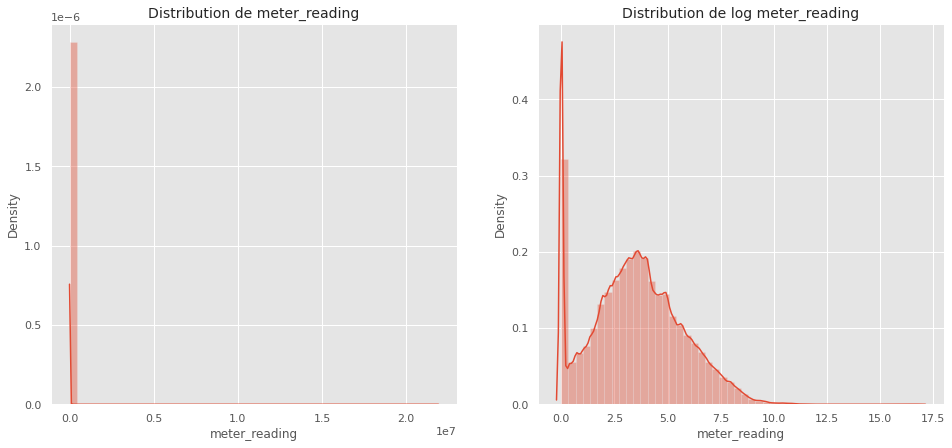

In [58]:
fig, axes = plt.subplots(1,2,figsize=(16, 7))

sns.distplot(train['meter_reading'], kde=True , ax = axes[0])
axes[0].set_title("Distribution de meter_reading", size=14)

sns.distplot(np.log1p(train['meter_reading']), kde=True, ax = axes[1])
axes[1].set_title("Distribution de log meter_reading", size=14)

plt.show()

Avec des valeurs de meters différents de 0

In [59]:
positive_train = train[train['meter_reading'] != 0]
positive_train['log_meter_reading'] = np.log(positive_train['meter_reading'])

On essaie d'afficher la distribution des valeurs de meters différents de zéro

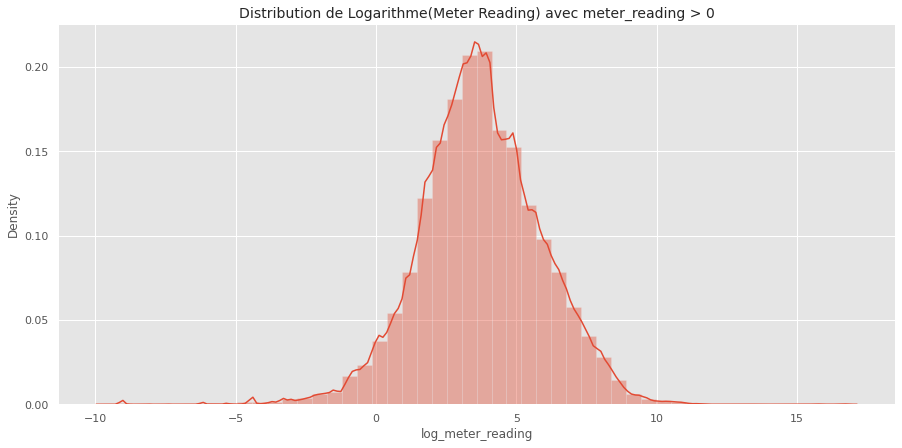

In [60]:
figsize(15,7)

sns.distplot(positive_train['log_meter_reading'], kde=True)
plt.title("Distribution de Logarithme(Meter Reading) avec meter_reading > 0", size=14)
plt.show()

## **meter reading sur différentes catégories de meter**

In [61]:
meters = sorted(train['meter'].unique().tolist())
print(meters)

[0, 1, 2, 3]


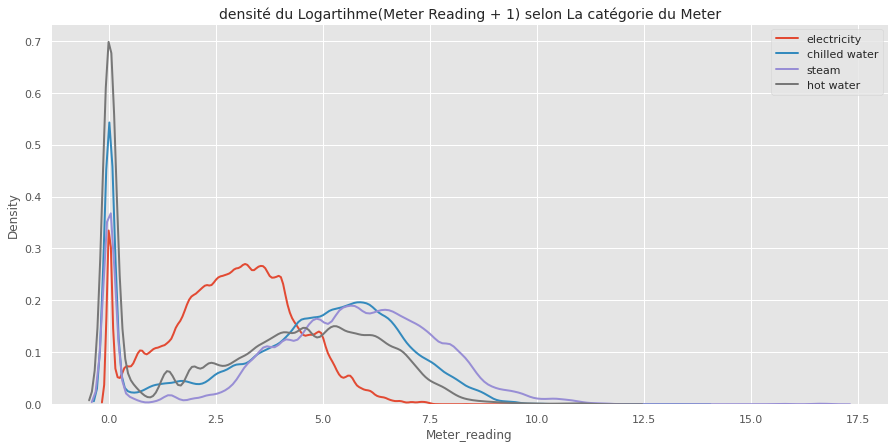

In [62]:
# plot la distribution de meter_reading selon la categorie de meter
figsize(15,7)
for meter_type in meters:
    subset = train[train['meter'] == meter_type]
    sns.kdeplot(np.log1p(subset["meter_reading"]), label=meter_type, linewidth=2)

plt.ylabel("Density")
plt.xlabel("Meter_reading")
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
plt.title("densité du Logartihme(Meter Reading + 1) selon La catégorie du Meter", size=14)
plt.show()

## **Etude mensuelle et par heures de chaque meter_reading**

### **electricity meter**

In [63]:
train.head()

,building_id,meter,timestamp,meter_reading,meter_cat,hour,dayofweek,month
0,0,0,2016-01-01,0.0,electricity,0,4,1
1,1,0,2016-01-01,0.0,electricity,0,4,1
2,2,0,2016-01-01,0.0,electricity,0,4,1
3,3,0,2016-01-01,0.0,electricity,0,4,1
4,4,0,2016-01-01,0.0,electricity,0,4,1


In [64]:
print(train)

          building_id  meter           timestamp  ...  hour dayofweek  month
0                   0      0 2016-01-01 00:00:00  ...     0         4      1
1                   1      0 2016-01-01 00:00:00  ...     0         4      1
2                   2      0 2016-01-01 00:00:00  ...     0         4      1
3                   3      0 2016-01-01 00:00:00  ...     0         4      1
4                   4      0 2016-01-01 00:00:00  ...     0         4      1
...               ...    ...                 ...  ...   ...       ...    ...
20216095         1444      0 2016-12-31 23:00:00  ...    23         5     12
20216096         1445      0 2016-12-31 23:00:00  ...    23         5     12
20216097         1446      0 2016-12-31 23:00:00  ...    23         5     12
20216098         1447      0 2016-12-31 23:00:00  ...    23         5     12
20216099         1448      0 2016-12-31 23:00:00  ...    23         5     12

[20216100 rows x 8 columns]


In [65]:
subset = train[train['meter'] == 'electricity']
print(subset)

Empty DataFrame
Columns: [building_id, meter, timestamp, meter_reading, meter_cat, hour, dayofweek, month]
Index: []


**Eau chilled**

In [66]:
def meter_reading_month_hour(category_meter):
    meter_list = ['electricity', 'chilledwater', 'steam',  'hotwater']
    colors = ['#7f7f7f' , '#1f77b4' , '#2ca02c' , '#9467bd']
    col = colors[meter_list.index(category_meter)]
    fig, axes = plt.subplots(1,2,figsize=(20, 6))

    subset = train[train['meter_cat'] == category_meter]
    per_month = subset.groupby('month')['meter_reading'].mean()
    per_hour = subset.groupby('hour')['meter_reading'].mean()

    axes[0].plot(per_month , color = col)
    axes[0].set_title('La moyenne de meter_reading par mois', fontsize=14);
    axes[0].set_ylabel('La moyenne de meter_reading', fontsize=14);
    axes[0].set_xlabel('mois' , fontsize= 14)
    axes[0].legend([category_meter])

    axes[1].plot(per_hour , color = col)
    axes[1].set_title('La moyenne de meter_reading par heure', fontsize=14);
    axes[1].set_ylabel('La moyenne de meter_reading', fontsize=14);
    axes[1].set_xlabel('heure' , fontsize= 14)
    axes[1].legend([category_meter])

    plt.show()

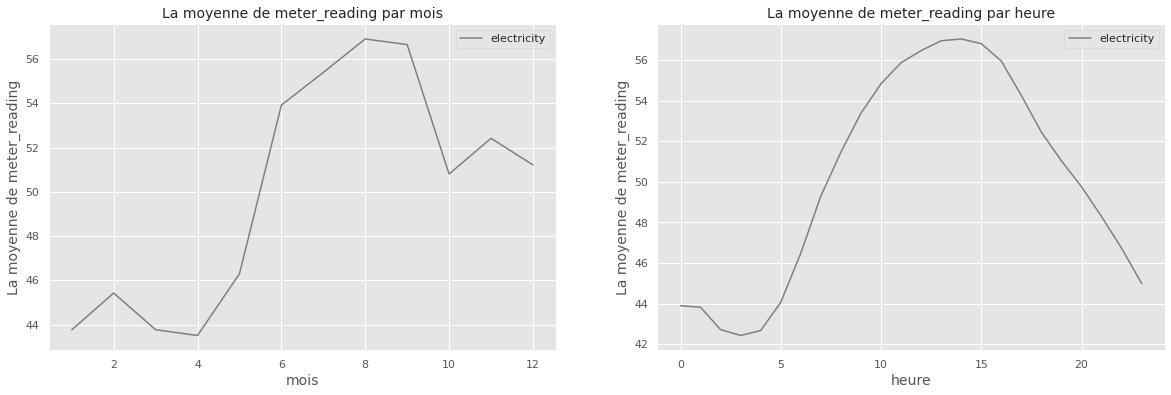

In [67]:
meter_reading_month_hour('electricity')

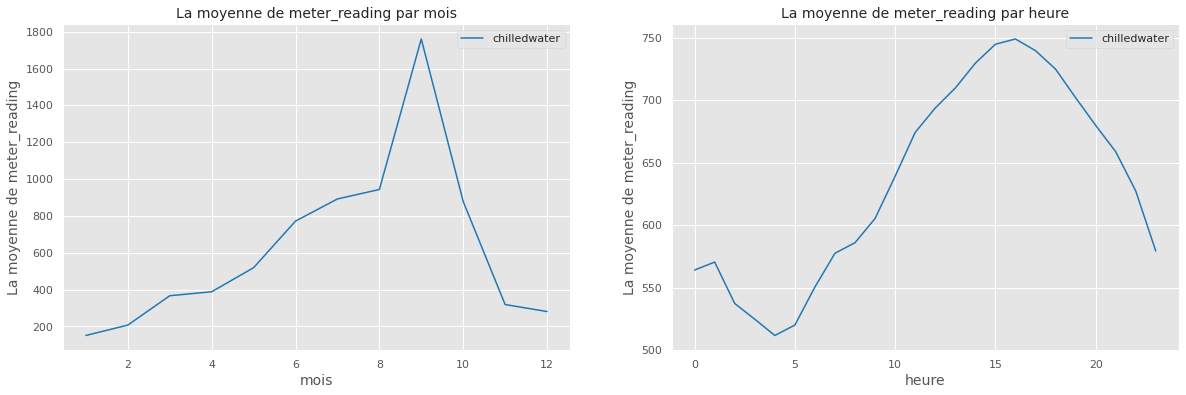

In [68]:
meter_reading_month_hour('chilledwater')

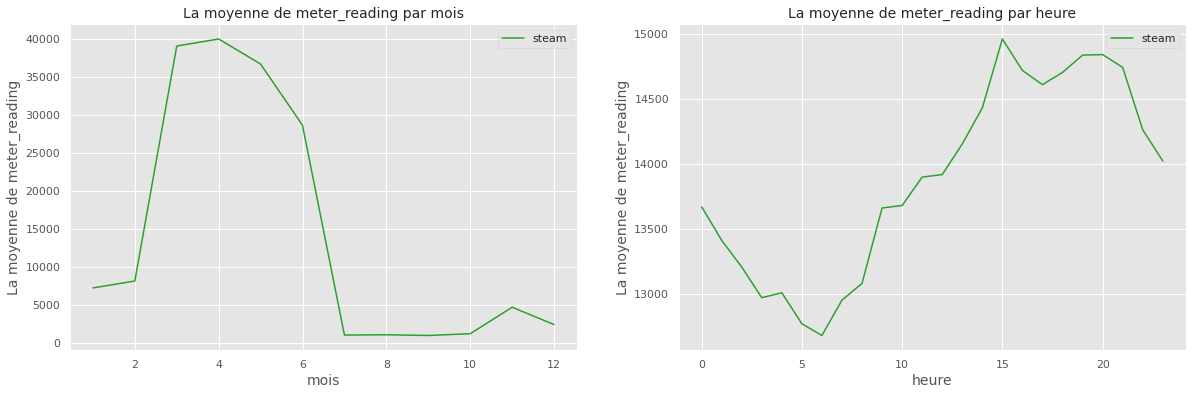

In [69]:
meter_reading_month_hour('steam')

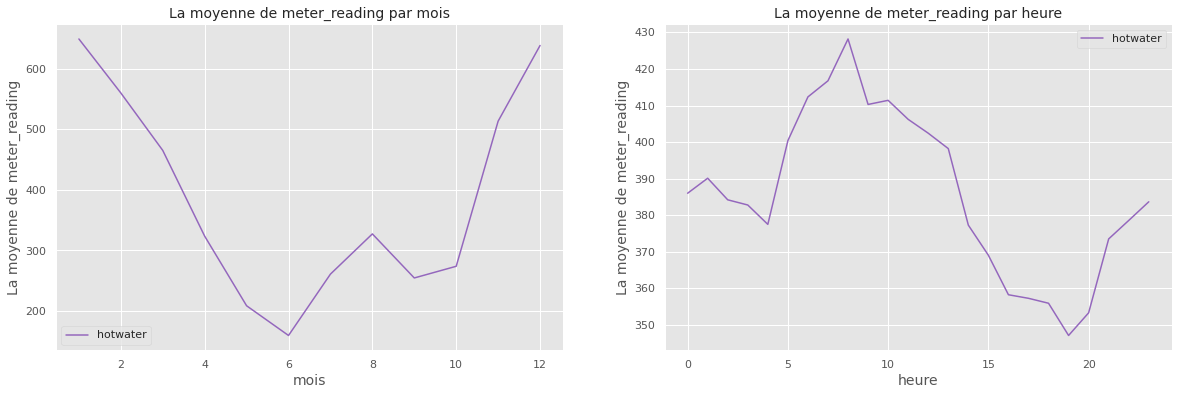

In [70]:
meter_reading_month_hour('hotwater')


outliers: Valeurs abérantes

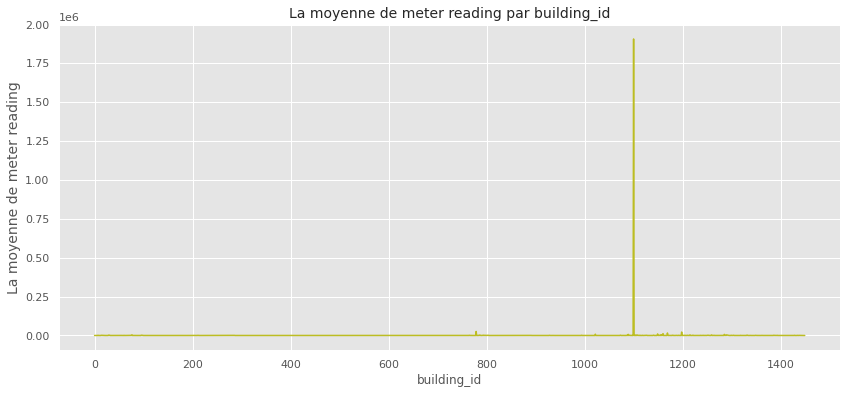

In [71]:

fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('building_id')['meter_reading'].mean().plot(color='#bcbd22');
axes.set_title('La moyenne de meter reading par building_id', fontsize=14);
axes.set_ylabel('La moyenne de meter reading', fontsize=14);

Dans le schéma on voit qu'une valeur à une valeur importante par rapport aux autres, on peut la considérer comme abérante.

In [72]:
train[train['building_id'] == 1099]['meter_reading'].describe()

count    1.756600e+04
mean     1.907222e+06
std      4.834778e+06
min      4.775332e+01
25%      1.526539e+02
50%      3.992344e+02
75%      7.008000e+03
max      2.190470e+07
Name: meter_reading, dtype: float64

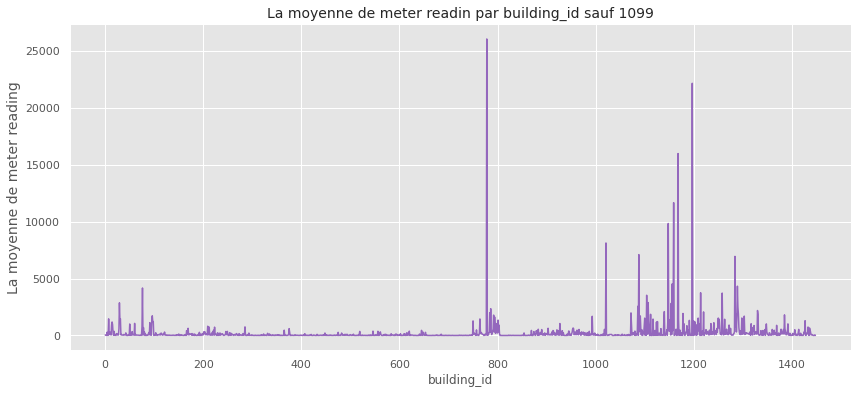

In [73]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train[train['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot(color='#9467bd');
axes.set_title('La moyenne de meter readin par building_id sauf 1099', fontsize=14);
axes.set_ylabel('La moyenne de meter reading', fontsize=14);

## **Weather data**

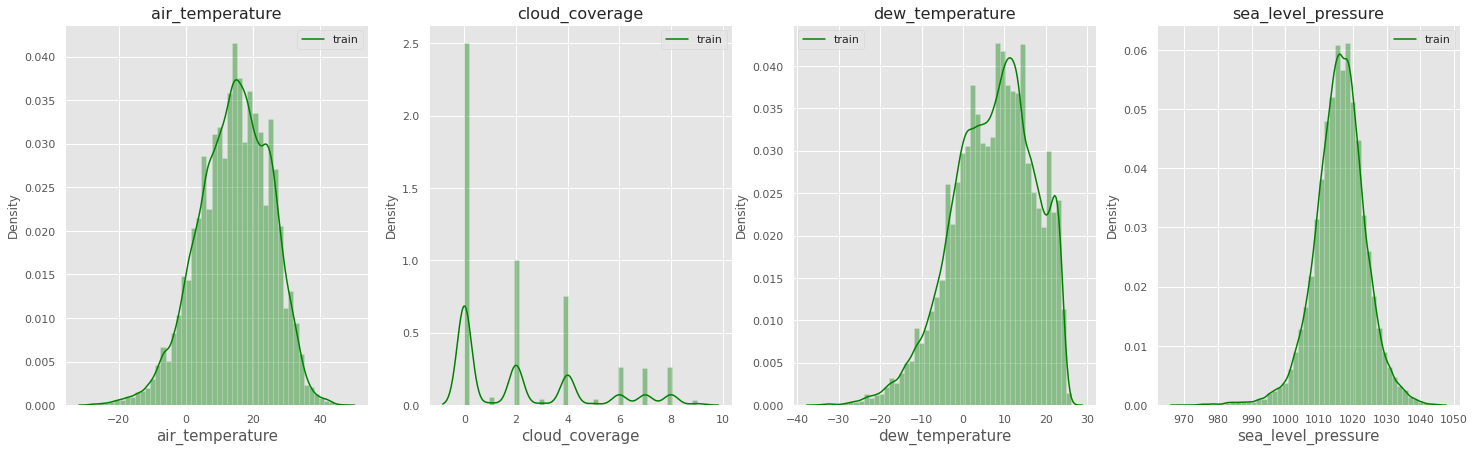

In [74]:
columns = ['air_temperature' , 'cloud_coverage' , 'dew_temperature' , 'sea_level_pressure']
fig, axs = plt.subplots(1, 4 , figsize = (25,7))
for i in range(len(columns)):
    sns.distplot(weather[columns[i]].dropna(), color='green', ax=axs[i]).set_title(columns[i], fontsize=16)

    axs[i].set_xlabel(columns[i], fontsize=15)
    axs[i].legend(['train'])
plt.show()


**Meter Reading among Site ID**

In [75]:
# group train dataset per building and meter category
trainble_df= (train.groupby(["building_id" , "meter"]).meter_reading.mean().reset_index())

In [76]:
print(trainble_df)

      building_id  meter  meter_reading
0               0      0      42.925953
1               1      0      21.943047
2               2      0       4.265011
3               3      0      69.039696
4               4      0     286.228790
...           ...    ...            ...
2375         1444      0       2.193011
2376         1445      0       1.387188
2377         1446      0       1.052863
2378         1447      0      54.844284
2379         1448      0       0.978542

[2380 rows x 3 columns]


In [7]:
trainble_df = (train.merge(building, on='building_id', how='left'))
trainble_df['log_meter_reading'] = np.log1p(trainble_df['meter_reading'])

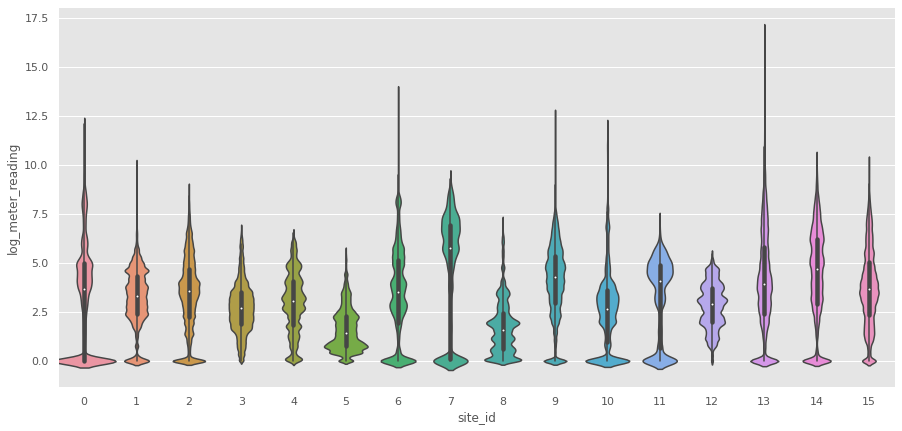

In [101]:
fig , ax = plt.subplots(1,1,figsize = (15,7))
sns.set(style="whitegrid")
ax = sns.violinplot(x='site_id', y='log_meter_reading',gridsize=200, width=1.2,scale='area',data=trainble_df)
plt.show()


Site ids 0, 1, 2, 3, 4, 5, 8, 9, 14 and 15 ont des distributions similaires de meter reading.

Site ids 6 and 10 meter_reading partagent presque la même distribution et les mêmes statistiques.

Site id 13 a la valeur plus large meter reading et la plus large distribution.

Site id 11 a la valeur la plus étroite ou pétite du meter reading centrée autour de 5.


**meter reading vs floor count**

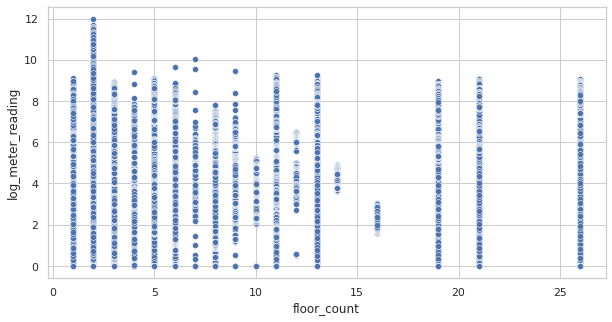

In [102]:
fig , ax = plt.subplots(1,1,figsize = (10,5))
ax = sns.scatterplot(x="floor_count", y="log_meter_reading",  data=trainble_df)
plt.show()

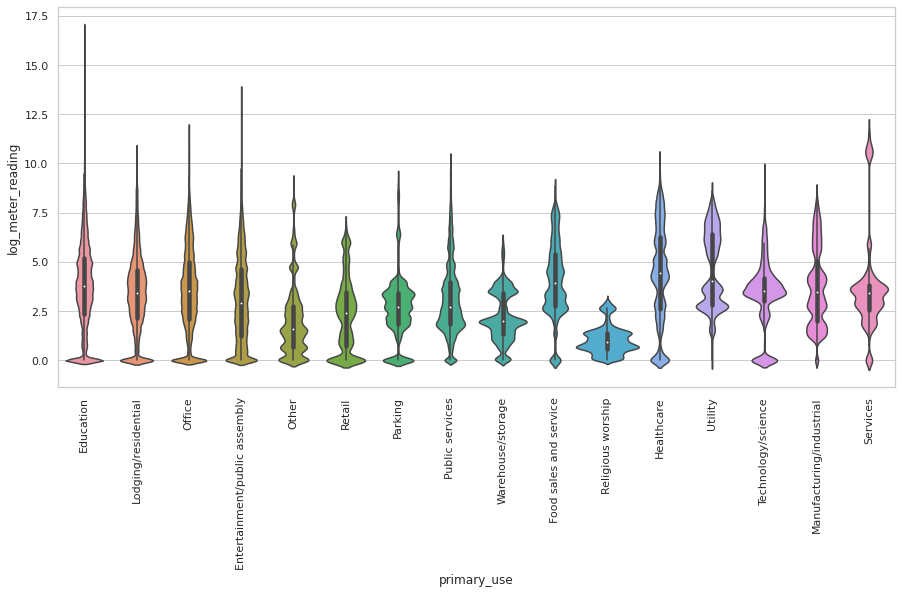

In [103]:
fig , ax = plt.subplots(1,1,figsize = (15,7))
sns.set(style="whitegrid")
ax = sns.violinplot(x='primary_use', y='log_meter_reading',gridsize=200, width=1.2,scale='area',data=trainble_df)
ax.set_xticklabels(ax.get_xticklabels() , rotation=90)
plt.show()

In [8]:
trainble_df = trainble_df.merge(weather, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')

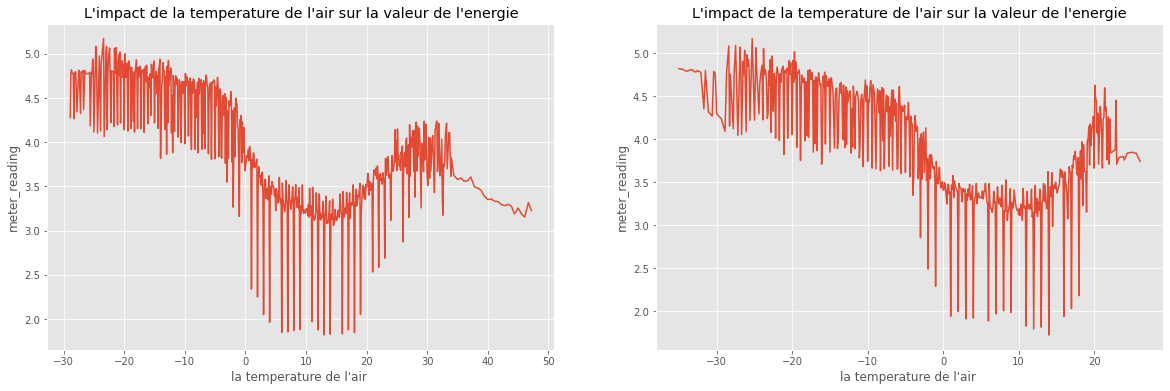

In [13]:
fig, axes = plt.subplots(1,2,figsize=(20, 6))
subset = trainble_df.groupby('air_temperature')['log_meter_reading'].mean()
axes[0].plot(subset)
axes[0].set_ylabel('meter_reading')
axes[0].set_xlabel('la temperature de l\'air ')
axes[0].set_title('L\'impact de la temperature de l\'air sur la valeur de l\'energie')

subset = trainble_df.groupby('dew_temperature')['log_meter_reading'].mean()
axes[1].plot(subset)
axes[1].set_ylabel('meter_reading')
axes[1].set_xlabel('la temperature de l\'air ')
axes[1].set_title('L\'impact de la temperature de l\'air sur la valeur de l\'energie')
plt.show()

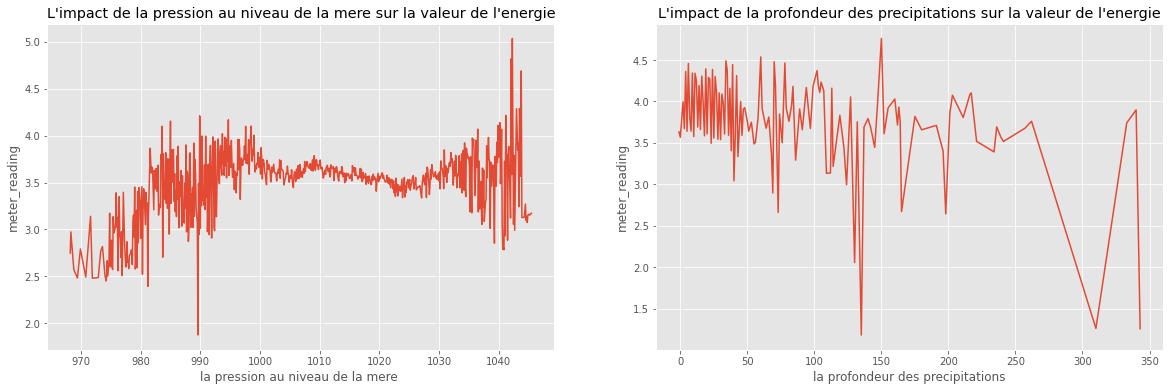

In [14]:
fig, axes = plt.subplots(1,2,figsize=(20, 6))
subset = trainble_df.groupby('sea_level_pressure')['log_meter_reading'].mean()
axes[0].plot(subset)
axes[0].set_ylabel('meter_reading')
axes[0].set_xlabel('la pression au niveau de la mere ')
axes[0].set_title('L\'impact de la pression au niveau de la mere sur la valeur de l\'energie')

subset = trainble_df.groupby('precip_depth_1_hr')['log_meter_reading'].mean()
axes[1].plot(subset)
axes[1].set_ylabel('meter_reading')
axes[1].set_xlabel('la profondeur des precipitations')
axes[1].set_title('L\'impact de la profondeur des precipitations sur la valeur de l\'energie')
plt.show()

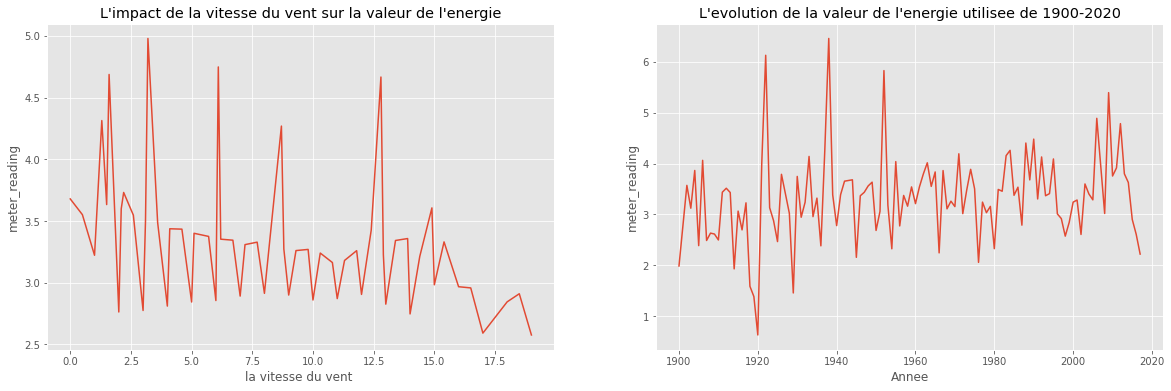

In [16]:
fig, axes = plt.subplots(1,2,figsize=(20, 6))
subset = trainble_df.groupby('wind_speed')['log_meter_reading'].mean()
axes[0].plot(subset)
axes[0].set_ylabel('meter_reading')
axes[0].set_xlabel('la vitesse du vent ')
axes[0].set_title('L\'impact de la vitesse du vent sur la valeur de l\'energie')

subset = trainble_df.groupby('year_built')['log_meter_reading'].mean()
axes[1].plot(subset)
axes[1].set_ylabel('meter_reading')
axes[1].set_xlabel('Annee')
axes[1].set_title('L\'evolution de la valeur de l\'energie utilisee de 1900-2020')

plt.show()